In [1]:
import sys
import os
sys.path.append('..')
import torchvision.transforms as T

from wildlife_tools.data import WildlifeDataset
from wildlife_tools.inference import KnnClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

import pandas as pd
import itertools
from torch.optim import SGD
from utils.trainer_pl import basic_trainer_pl
from models.template_model import TemplateModel
from utils.triplet_loss_utils import TripletLoss_wildlife

from utils.triplet_loss_utils import KnnClassifier
from wildlife_tools.similarity import CosineSimilarity
from sklearn.metrics import precision_score, recall_score, f1_score

import timm
import torch.nn as nn
from pytorch_lightning import LightningModule
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_lightning import Trainer
import numpy as np
from PIL import Image
import wandb
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from wildlife_datasets import analysis, datasets, loader
from wildlife_tools.features import DeepFeatures
from utils.visualization import query_prediction_results, query_prediction_results_similarity
from data.wildlife_dataset import WildlifeDataModule
from data.raptors_wildlife import Raptors, GoldensWildlife




/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
# Reproduce what combined_datasets does but without config and with local paths.
# this uses CACHE
# create a config dict
config = {}
config['wildlife_name'] = "raptors, BirdIndividualID, ATRW, whaleshark"
config['animal_cat'] = ['bird', 'bird', 'mammal', 'fish']
config['dataset'] = '/Users/amee/Documents/code/master-thesis/datasets/'
config['cache_path']= '/Users/amee/Documents/code/master-thesis/EagleID/dataset/dataframe/cache_multispecies2.csv'
config['preprocess_lvl'] = 0 # NO PREPROCESSING
config['batch_size'] = 4
config['num_workers'] = 1
config['img_size'] = 224
config['transforms'] = {}
config['transforms']['mean'] = [0.485, 0.456, 0.406]
config['transforms']['std'] = [0.229, 0.224, 0.225]
config['split_ratio'] = 0.8
config['splitter'] = 'closed'
config['only_cache'] = False # FALSE
config['arcface_loss'] = {}
config['arcface_loss']['n_classes'] = 0


cache_df = pd.read_csv(config['cache_path'])
cache_df['identity'] = cache_df['wildlife_name'] + '-' + cache_df['identity'].astype(str)

raptor_path = os.path.join(config['dataset'], 'raptor_individuals_cropped')
birds_path = os.path.join(config['dataset'], 'BirdIndividualID')
atrw_path = os.path.join(config['dataset'], 'ATRW')
whaleshark_path = os.path.join(config['dataset'], 'EDA-whaleshark')

# dataset1 = Raptors(root=raptor_path, include_video=False)
# dataset1.df['wildlife_name'] = 'raptors'
# dataset1.df['path'] = dataset1.df['path'].apply(lambda x: os.path.join('raptor_individuals_cropped', x))
# dataset1.df['identity'] = dataset1.df['identity'].apply(lambda x: 'raptors-' + str(x))
# dataset2 = datasets.BirdIndividualID(birds_path)
# dataset2.df['wildlife_name'] = 'BirdIndividualID'
# dataset2.df['path'] = dataset2.df['path'].apply(lambda x: os.path.join('BirdIndividualID', x))
# dataset2.df['identity'] = dataset2.df['identity'].apply(lambda x: 'bird-' + str(x))
# dataset3 = datasets.WhaleSharkID(whaleshark_path)
# dataset3.df['wildlife_name'] = 'whaleshark'
# dataset3.df['path'] = dataset3.df['path'].apply(lambda x: os.path.join('EDA-whaleshark', x))
# dataset3.df['identity'] = dataset3.df['identity'].apply(lambda x: 'whaleshark-' + str(x))
# dataset4 = datasets.ATRW(atrw_path)
# dataset4.df['wildlife_name'] = 'ATRW'
# dataset4.df['path'] = dataset4.df['path'].apply(lambda x: os.path.join('ATRW', x))
# dataset4.df['identity'] = dataset4.df['identity'].apply(lambda x: 'ATRW-' + str(x))

# dataset_df = pd.concat([dataset1.df, dataset2.df, dataset3.df, dataset4.df], ignore_index=True)

data = WildlifeDataModule(metadata=cache_df, config = config)

Dataset size before pre-processing and cleaning: 11361
Split: closed-set
Samples: train/test/unassigned/total = 8989/2311/0/11300
Classes: train/test/unassigned/total = 608/608/0/608
Classes: train only/test only/joint  = 0/0/608

Fraction of train set     = 79.55%
Fraction of test set only = 0.00%
Training Set
Length: 8989
Number of individuals (classes): 608
Mean images/individual: 14.78453947368421
Min images/individual: 1
Max images/individual: 188
Test Set
Length: 2311
Number of individuals (classes): 608
Mean images per individual: 3.8009868421052633
Min images per individual: 1
Max images per individual: 47


In [2]:
# Reproduce what combined_datasets does but without config and with local paths.
# this uses NO cache
# create a config dict
config = {}
config['wildlife_name'] = "raptors, BirdIndividualID, ATRW, whaleshark"
config['animal_cat'] = ['bird', 'bird', 'mammal', 'fish']
config['dataset'] = '/Users/amee/Documents/code/master-thesis/datasets/'
config['cache_path']= ''
config['preprocess_lvl'] = 0 # NO PREPROCESSING
config['batch_size'] = 4
config['num_workers'] = 1
config['img_size'] =224
config['transforms'] = {}
config['transforms']['mean'] = [0.485, 0.456, 0.406]
config['transforms']['std'] = [0.229, 0.224, 0.225]
config['split_ratio'] = 0.8
config['splitter'] = 'closed'
config['only_cache'] = False # FALSE
config['arcface_loss'] = {}
config['arcface_loss']['n_classes'] = 0


raptor_path = os.path.join(config['dataset'], 'raptor_individuals_cropped')
birds_path = os.path.join(config['dataset'], 'BirdIndividualID')
atrw_path = os.path.join(config['dataset'], 'ATRW')
whaleshark_path = os.path.join(config['dataset'], 'EDA-whaleshark')

dataset1 = Raptors(root=raptor_path, include_video=False)
dataset1.df['wildlife_name'] = 'raptors'
dataset1.df['path'] = dataset1.df['path'].apply(lambda x: os.path.join('raptor_individuals_cropped', x))
dataset1.df['identity'] = dataset1.df['identity'].apply(lambda x: 'raptors-' + str(x))
dataset2 = datasets.BirdIndividualID(birds_path)
dataset2.df['wildlife_name'] = 'BirdIndividualID'
dataset2.df['path'] = dataset2.df['path'].apply(lambda x: os.path.join('BirdIndividualID', x))
dataset2.df['identity'] = dataset2.df['identity'].apply(lambda x: 'bird-' + str(x))
dataset3 = datasets.WhaleSharkID(whaleshark_path)
dataset3.df['wildlife_name'] = 'whaleshark'
dataset3.df['path'] = dataset3.df['path'].apply(lambda x: os.path.join('EDA-whaleshark', x))
dataset3.df['identity'] = dataset3.df['identity'].apply(lambda x: 'whaleshark-' + str(x))
dataset4 = datasets.ATRW(atrw_path)
dataset4.df['wildlife_name'] = 'ATRW'
dataset4.df['path'] = dataset4.df['path'].apply(lambda x: os.path.join('ATRW', x))
dataset4.df['identity'] = dataset4.df['identity'].apply(lambda x: 'ATRW-' + str(x))

dataset_df = pd.concat([dataset1.df, dataset2.df, dataset3.df, dataset4.df], ignore_index=True)

data = WildlifeDataModule(metadata=dataset_df, config = config)

Dataset size before pre-processing and cleaning: 66052
Split: closed-set
Samples: train/test/unassigned/total = 52760/13261/0/66021
Classes: train/test/unassigned/total = 814/814/0/814
Classes: train only/test only/joint  = 0/0/814

Fraction of train set     = 79.91%
Fraction of test set only = 0.00%
Training Set
Length: 52760
Number of individuals (classes): 814
Mean images/individual: 64.81572481572482
Min images/individual: 1
Max images/individual: 1408
Test Set
Length: 13261
Number of individuals (classes): 814
Mean images per individual: 16.291154791154792
Min images per individual: 1
Max images per individual: 352


In [ ]:
# Reproduce just ONE animal 
# create a config dict
config = {}
config['wildlife_name'] = 'ATRW'
config['animal_cat'] = 'mammal'
config['dataset'] = '/Users/amee/Documents/code/master-thesis/datasets/ATRW'
config['cache_path']= '/Users/amee/Documents/code/master-thesis/EagleID/dataset/dataframe/cache_ATRW.csv'
config['preprocess_lvl'] = 0 # NO PREPROCESSING
config['batch_size'] = 4
config['num_workers'] = 1
config['img_size'] =224
config['transforms'] = {}
config['transforms']['mean'] = [0.485, 0.456, 0.406]
config['transforms']['std'] = [0.229, 0.224, 0.225]
config['split_ratio'] = 0.8
config['splitter'] = 'closed' # NOT original_split (for comparison only)
config['only_cache'] = False # FALSE
config['arcface_loss'] = {}
config['arcface_loss']['n_classes'] = 0
config['custom_transform'] = True


dataset1 = datasets.ATRW(root=config['dataset'])
dataset1.df['wildlife_name'] = 'ATRW'
# dataset1.df["bbox"] = dataset1.df["bbox"].fillna("[0,0,0,0]")


dataset_df = dataset1.df

data = WildlifeDataModule(metadata=dataset_df, config = config)

Dataset size before pre-processing and cleaning: 5415
Split: closed-set
Samples: train/test/unassigned/total = 4340/1075/0/5415
Classes: train/test/unassigned/total = 182/182/0/182
Classes: train only/test only/joint  = 0/0/182

Fraction of train set     = 80.15%
Fraction of test set only = 0.00%
Training Set
Length: 4340
Number of individuals (classes): 182
Mean images/individual: 23.846153846153847
Min images/individual: 8
Max images/individual: 200
Test Set
Length: 1075
Number of individuals (classes): 182
Mean images per individual: 5.906593406593407
Min images per individual: 2
Max images per individual: 50


In [14]:
dataset_df

,image_id,identity,path,bbox,date,orientation,wildlife_name
0,0,10563a2a-4c62-e8c9-e5a5-8582bf2eb059,whaleshark.coco/images/train2020/000000000001.jpg,"[18, 582, 2412, 1248]",unknown,right,whaleshark
1,1,341569f2-1f34-4884-1dd3-79137be4c77f,whaleshark.coco/images/train2020/000000000002.jpg,"[511, 237, 2387, 1275]",unknown,left,whaleshark
2,2,69f95579-8a42-8d93-8d78-7b641952933c,whaleshark.coco/images/train2020/000000000003.jpg,"[317, 627, 2196, 832]",unknown,left,whaleshark
3,3,26560de1-6930-ddaf-5069-f7b85acd40fb,whaleshark.coco/images/train2020/000000000004.jpg,"[78, 7, 2898, 2006]",unknown,left,whaleshark
4,4,a785af89-b8c0-5e7b-acec-c4874ec5483f,whaleshark.coco/images/train2020/000000000005.jpg,"[198, 414, 2788, 1561]",2017-02-28 12:28:49,left,whaleshark
...,...,...,...,...,...,...,...
7688,7688,431741cc-839f-cbaf-9859-162abfa36ba4,whaleshark.coco/images/train2020/000000007689.jpg,"[0, 254, 2996, 2171]",unknown,left,whaleshark
7689,7689,13358d13-b940-7836-2d35-d00e8310b297,whaleshark.coco/images/train2020/000000007690.jpg,"[624, 479, 2120, 1512]",unknown,back,whaleshark
7690,7690,ecec2054-01c7-ed9d-94c6-603a3836f2f2,whaleshark.coco/images/train2020/000000007691.jpg,"[0, 192, 2917, 2191]",unknown,right,whaleshark
7691,7691,461d166d-0321-fe1b-8796-dbcb72672a64,whaleshark.coco/images/train2020/000000007692.jpg,"[53, 287, 2941, 2092]",unknown,left,whaleshark


In [7]:
pd.set_option("display.max_columns", None)
df = dataset_df
# Find rows where a column has NaN values
nan_rows = df[df["bbox"].isna()]

# Display the rows with NaN values in "keypoints"
nan_rows
# df

,image_id,species,identity_id,identity,path,from_video,video,date,wildlife_name,original_split,bbox,orientation,keypoints
0,0,whteag,0.0,England_G818,raptor_individuals_cropped/whteag/England_G818...,False,None,2024,raptors,NaN,NaN,NaN,NaN
1,1,whteag,0.0,England_G818,raptor_individuals_cropped/whteag/England_G818...,False,None,2024,raptors,NaN,NaN,NaN,NaN
2,2,whteag,0.0,England_G818,raptor_individuals_cropped/whteag/England_G818...,False,None,2024,raptors,NaN,NaN,NaN,NaN
3,3,whteag,1.0,England_G471,raptor_individuals_cropped/whteag/England_G471...,False,None,2021,raptors,NaN,NaN,NaN,NaN
4,4,whteag,1.0,England_G471,raptor_individuals_cropped/whteag/England_G471...,False,None,2022,raptors,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66046,ffc58105bf6f8a91,NaN,NaN,172,ATRW/atrw_reid_train/train/004001.jpg,NaN,NaN,unknown,ATRW,train,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
66048,ffd52f3c7e12435a,NaN,NaN,220,ATRW/atrw_reid_train/train/000373.jpg,NaN,NaN,unknown,ATRW,train,NaN,NaN,"[208, 1, 2, 237, 6, 2, 0, 0, 0, 191, 104, 2, 1..."
66049,ffeabd223de0d4ea,NaN,NaN,60,ATRW/atrw_reid_train/train/000575.jpg,NaN,NaN,unknown,ATRW,train,NaN,NaN,"[55, 99, 2, 28, 80, 2, 2, 129, 2, 65, 184, 2, ..."
66050,ffedf5be3a86e2ee,NaN,NaN,267,ATRW/atrw_reid_train/train/002302.jpg,NaN,NaN,unknown,ATRW,train,NaN,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
pd.set_option("display.max_columns", None)
print(len(data.train_dataset.metadata))
data.train_dataset.metadata

4340


,image_id,identity,path,bbox,keypoints,original_split,wildlife_name
0,d914a6c6d93c8df0,0,atrw_reid_train/train/004759.jpg,NaN,"[194, 233, 2, 204, 85, 2, 59, 362, 2, 0, 0, 0,...",train,ATRW
1,8f4576ad85410442,0,atrw_reid_train/train/004648.jpg,NaN,"[0, 0, 0, 1207, 378, 2, 1245, 448, 2, 1114, 49...",train,ATRW
2,375c71349b295fbe,0,atrw_reid_train/train/001703.jpg,NaN,"[200, 283, 2, 184, 121, 2, 29, 402, 2, 0, 0, 0...",train,ATRW
3,2288f691b58edeca,0,atrw_reid_train/train/002558.jpg,NaN,"[215, 243, 2, 242, 85, 2, 98, 348, 2, 446, 412...",train,ATRW
4,abec16f483abb4f1,0,atrw_reid_train/train/003997.jpg,NaN,"[232, 333, 2, 159, 162, 2, 36, 477, 2, 0, 0, 0...",train,ATRW
...,...,...,...,...,...,...,...
4335,7c4bf50b715509a9,274,atrw_reid_train/train/002684.jpg,NaN,"[0, 0, 0, 385, 89, 2, 409, 169, 2, 215, 140, 2...",train,ATRW
4336,061412e4a03c02f9,274,atrw_reid_train/train/000896.jpg,NaN,"[0, 0, 0, 428, 99, 2, 457, 180, 2, 274, 153, 2...",train,ATRW
4337,6e0721b2c6977135,274,atrw_reid_train/train/000783.jpg,NaN,"[360, 74, 2, 383, 95, 2, 375, 169, 2, 204, 154...",train,ATRW
4338,d7657583058394c8,274,atrw_reid_train/train/001838.jpg,NaN,"[530, 110, 2, 520, 130, 2, 555, 204, 2, 447, 1...",train,ATRW


In [5]:
data.val_query_dataset.metadata

,image_id,species,identity_id,identity,path,from_video,video,date,segmentation,height,...,iscrowd,keypoints,num_keypoints,orientation,wildlife_name,original_split,width.1,height.1,identity_idx,query
0,02a32ad2669e6fe2,NaN,NaN,ATRW-0,ATRW/atrw_reid_train/train/000841.jpg,NaN,NaN,NaN,"[[206.09375, 83.0546875, 204.03280639648438, 8...",805.0,...,0.0,"[154, 150, 2, 132, 206, 2, 132, 195, 2, 177, 3...",23.0,NaN,ATRW,train,NaN,NaN,NaN,True
1,2b0f658cbffd2849,NaN,NaN,ATRW-1,ATRW/atrw_reid_train/train/002035.jpg,NaN,NaN,NaN,"[[555.8296508789062, 78.46406555175781, 554.50...",600.0,...,0.0,"[775, 122, 2, 783, 191, 2, 783, 191, 2, 775, 2...",23.0,NaN,ATRW,train,NaN,NaN,NaN,True
2,0a233828e1d63e45,NaN,NaN,ATRW-10,ATRW/atrw_detection_test/test/3007.jpg,NaN,NaN,NaN,"[[959.4812622070312, 219.79998779296875, 956.9...",1080.0,...,0.0,"[1468, 277, 2, 1668, 369, 2, 1591, 338, 2, 157...",23.0,NaN,ATRW,test,NaN,NaN,NaN,True
3,8420d35940402456,NaN,NaN,ATRW-100,ATRW/atrw_reid_train/train/002683.jpg,NaN,NaN,NaN,"[[398.7656555175781, 38.51250076293945, 397.06...",525.0,...,0.0,"[1009, 178, 2, 1041, 230, 2, 1030, 220, 2, 103...",23.0,NaN,ATRW,train,NaN,NaN,NaN,True
4,15296db0ffeba1f3,NaN,NaN,ATRW-102,ATRW/atrw_detection_test/test/2874.jpg,NaN,NaN,NaN,"[[920.5499877929688, 391.8812503814697, 918.89...",1080.0,...,0.0,"[456, 427, 2, 429, 473, 2, 411, 482, 2, 402, 5...",23.0,NaN,ATRW,test,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,6603,NaN,NaN,whaleshark-f3517380-12f0-d64b-9d7e-c4029305c90e,EDA-whaleshark/whaleshark.coco/images/train202...,NaN,NaN,unknown,"[[44.890625, 311.90625, 35.59375, 321.203125, ...",2400.0,...,0.0,"[775, 622, 2, 228, 1055, 0, 2908, 882, 0, 228,...",23.0,right,whaleshark,NaN,NaN,NaN,NaN,True
351,3499,NaN,NaN,whaleshark-f8433e57-cab6-66d3-4b86-87aa9b50fc38,EDA-whaleshark/whaleshark.coco/images/train202...,NaN,NaN,unknown,"[[1022.3031005859375, 459.1124954223633, 1018....",1789.0,...,0.0,"[2426, 753, 2, 2468, 774, 2, 2489, 774, 2, 259...",23.0,right,whaleshark,NaN,NaN,NaN,NaN,True
352,113,NaN,NaN,whaleshark-fb00d262-d8b7-13dc-0cf7-2cd99c42b5a8,EDA-whaleshark/whaleshark.coco/images/train202...,NaN,NaN,unknown,"[[1131.9749755859375, 313.84999084472656, 1127...",2408.0,...,0.0,"[2089, 531, 2, 2115, 713, 0, 2192, 713, 0, 260...",23.0,right,whaleshark,NaN,NaN,NaN,NaN,True
353,1238,NaN,NaN,whaleshark-fd39063f-b353-c2af-99a7-0c87114472c9,EDA-whaleshark/whaleshark.coco/images/train202...,NaN,NaN,unknown,"[[753.7750244140625, 699.5500030517578, 749.30...",2400.0,...,0.0,"[2742, 1002, 2, 2852, 1029, 2, 2852, 1057, 2, ...",23.0,right,whaleshark,NaN,NaN,NaN,292.0,True


In [16]:
data.val_gallery_dataset.metadata

,image_id,identity,path,bbox,keypoints,original_split,wildlife_name,tmp_idx,query
0,0060ef47b12160b9,18,atrw_reid_test/test/003492.jpg,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,ATRW,1,False
1,020a27c5036cf526,156,atrw_detection_test/test/1500.jpg,"[948, 401, 852, 471]",NaN,test,ATRW,12,False
2,02114a6e2abe7d76,112,atrw_detection_test/test/0420.jpg,"[743, 241, 481, 268]",NaN,test,ATRW,2,False
3,02180771a9b609a2,169,atrw_reid_test/test/002951.jpg,NaN,"[0, 0, 0, 286, 91, 2, 315, 117, 2, 227, 143, 2...",test,ATRW,9,False
4,024e62bb64490e0d,169,atrw_detection_test/test/4328.jpg,"[146, 464, 318, 237]",NaN,test,ATRW,9,False
...,...,...,...,...,...,...,...,...,...
3448,ff7d0f525b3be596,87,atrw_reid_test/test/001912.jpg,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,ATRW,45,False
3449,ffa066f645dc5a18,189,atrw_detection_test/test/3993.jpg,"[882, 587, 266, 221]",NaN,test,ATRW,32,False
3450,ffa758c7df1d8b50,84,atrw_detection_test/test/2452.jpg,"[822, 542, 405, 262]",NaN,test,ATRW,31,False
3451,ffcf86475fe9dc67,180,atrw_detection_test/test/1108.jpg,"[118, 189, 1484, 807]",NaN,test,ATRW,64,False


In [8]:
pd.set_option("display.max_columns", None)
df = data.train_dataset.metadata
# Find rows where "keypoints" column has NaN values
# tmp_rows = df[df["bbox"].isna()]
tmp_rows = df[df["wildlife_name"] == "raptors"]

# Display the rows with NaN values in "keypoints"
tmp_rows
# df

,image_id,species,identity_id,identity,path,from_video,video,date,segmentation,height,width,bbox,area,iscrowd,keypoints,num_keypoints,orientation,wildlife_name,original_split,width.1,height.1,identity_idx,query
5887,274,goleag,33.0,raptors-Alabama_natchez,raptor_individuals_cropped/goleag/Alabama_natc...,False,NaN,2000,"[[1027.6500244140625, 265.1999816894531, 1025....",1224.0,1632.0,"[387.6000061035156, 265.1999816894531, 1241.84...",1008001.0,0.0,"[1029, 288, 2, 873, 528, 2, 861, 528, 2, 430, ...",23.0,NaN,raptors,NaN,NaN,NaN,NaN,NaN
5888,273,goleag,33.0,raptors-Alabama_natchez,raptor_individuals_cropped/goleag/Alabama_natc...,False,NaN,2000,"[[101.9078140258789, 13.087499618530273, 101.3...",111.0,377.0,"[14.137499809265137, 13.087499618530273, 351.6...",14152.0,0.0,"[190, 41, 2, 197, 44, 2, 186, 41, 2, 193, 55, ...",23.0,NaN,raptors,NaN,NaN,NaN,NaN,NaN
5889,283,goleag,36.0,raptors-Bernheim_athena,raptor_individuals_cropped/goleag/Bernheim_ath...,False,NaN,2023,"[[730.25, 166.60000610351562, 727.075012207031...",1146.0,2032.0,"[177.8000030517578, 166.60000610351562, 1539.8...",1101711.0,0.0,"[773, 186, 2, 1044, 487, 2, 1059, 502, 2, 1645...",23.0,NaN,raptors,NaN,NaN,NaN,NaN,NaN
5890,284,goleag,36.0,raptors-Bernheim_athena,raptor_individuals_cropped/goleag/Bernheim_ath...,False,NaN,2000,"[[377.0078125, 9.0625, 376.3031311035156, 9.76...",300.0,451.0,"[2.8187501430511475, 9.0625, 437.6109373569488...",66754.0,0.0,"[367, 28, 2, 397, 33, 2, 393, 37, 2, 431, 37, ...",23.0,NaN,raptors,NaN,NaN,NaN,NaN,NaN
5891,282,goleag,36.0,raptors-Bernheim_athena,raptor_individuals_cropped/goleag/Bernheim_ath...,False,NaN,2023,"[[256.1062316894531, 20.749998092651367, 253.1...",277.0,628.0,"[39.25, 20.749998092651367, 560.2937622070312,...",64045.0,0.0,"[97, 51, 2, 86, 78, 2, 86, 83, 2, 48, 83, 2, 8...",23.0,NaN,raptors,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6279,298,goleag,38.0,raptors-SouthScotland_tarrasA31,raptor_individuals_cropped/goleag/SouthScotlan...,False,NaN,2021,"[[350.6031494140625, 173.6374969482422, 349.10...",958.0,800.0,"[4.824999809265137, 173.6374969482422, 793.343...",309297.0,0.0,"[373, 188, 2, 404, 242, 2, 350, 242, 2, 388, 2...",23.0,NaN,raptors,NaN,NaN,NaN,NaN,NaN
6280,293,goleag,38.0,raptors-SouthScotland_tarrasA31,raptor_individuals_cropped/goleag/SouthScotlan...,False,NaN,2000,"[[1327.519287109375, 698.6153564453125, 1322.9...",1912.0,2940.0,"[1322.923095703125, 698.6153564453125, 41.3653...",1563.0,0.0,"[1359, 727, 0, 1332, 735, 0, 1337, 715, 0, 132...",23.0,NaN,raptors,NaN,NaN,NaN,NaN,NaN
6281,485,goleag,64.0,raptors-SouthScotland_thistleH03,raptor_individuals_cropped/goleag/SouthScotlan...,False,NaN,2000,"[[37.812503814697266, 7.03125, 37.617191314697...",125.0,110.0,"[25.312501907348633, 7.03125, 37.8906269073486...",1268.0,0.0,"[45, 63, 2, 35, 63, 2, 36, 62, 2, 50, 70, 2, 3...",23.0,NaN,raptors,NaN,NaN,NaN,NaN,NaN
6282,481,goleag,64.0,raptors-SouthScotland_thistleH03,raptor_individuals_cropped/goleag/SouthScotlan...,False,NaN,2000,"[[38.69999694824219, 19.224998474121094, 38.47...",56.0,144.0,"[15.524999618530273, 19.224998474121094, 66.59...",505.0,0.0,"[57, 23, 2, 59, 24, 2, 57, 24, 2, 61, 27, 2, 6...",23.0,NaN,raptors,NaN,NaN,NaN,NaN,NaN


In [17]:
# Start the trainer
metadata = data.train_dataset.metadata
# Download MegaDescriptor-T backbone from HuggingFace Hub
backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-T-224', num_classes=0, pretrained=True)

# Arcface loss - needs backbone output size and number of classes.
objective = TripletLoss_wildlife()

# Optimize parameters in backbone and in objective using single optimizer.
params = itertools.chain(backbone.parameters(), objective.parameters())
optimizer = SGD(params=params, lr=0.001, momentum=0.9)

def print_epoch_loss(trainer, epoch_data):
    # This function will print the average loss at the end of each epoch
    print(f"Epoch {trainer.epoch}: Average Loss = {epoch_data['train_loss_epoch_avg']}")


trainer = basic_trainer_pl(
    dataset=metadata,
    model=backbone,
    objective=objective,
    optimizer=optimizer,
    epochs=0,
    device='cpu',
    epoch_callback=print_epoch_loss
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name        | Type                 | Params | Mode 
-------------------------------------------------------------
0 | model       | SwinTransformer      | 27.5 M | train
1 | loss_module | TripletLoss_wildlife | 0      | train
-------------------------------------------------------------
27.5 M    Trainable params
0         Non-trainable params
27.5 M    Total params
110.077   Total estimated model params size (MB)
/Users/amee/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/amee/miniconda3/env

In [8]:
# Evaluate the model in retrieval metrics
backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-T-224', num_classes=0, pretrained=True)


# dataset_database_P = WildlifeDataset(metadata.df.iloc[100:,:], metadata.root, transform=transform)
# dataset_query_P = WildlifeDataset(metadata.df.iloc[:100,:], metadata.root, transform=transform)
dataset_query_P = data.val_query_dataset
dataset_database_P = data.val_gallery_dataset

# name = 'hf-hub:BVRA/MegaDescriptor-T-224'
extractor_P = DeepFeatures(backbone , device = 'cpu')

query_P, database_P = extractor_P(dataset_query_P), extractor_P(dataset_database_P)

similarity_function = CosineSimilarity()
similarity_P = similarity_function(query_P, database_P)
print(similarity_P)
classifier_P = KnnClassifier(k=1, database_labels=dataset_database_P.labels_string)
predictions_P = classifier_P(similarity_P['cosine'])
print("Predictions for 100 test Images:-\n",predictions_P)
accuracy_P = np.mean(dataset_query_P.labels_string == predictions_P)
print("Accuracy on ATRW data: {:.2f}%".format(accuracy_P * 100))

precision_P = precision_score(dataset_query_P.labels_string, predictions_P, average='weighted',zero_division=1)
recall_P = recall_score(dataset_query_P.labels_string, predictions_P, average='weighted',zero_division=1)
f1_P = f1_score(dataset_query_P.labels_string, predictions_P, average='weighted',zero_division=1)
print("Precision:", precision_P)
print("Recall:", recall_P)
print("F1 Score:", f1_P)


100%|█████████████████████████████████████████████████████████████████| 7/7 [01:10<00:00, 10.07s/it]

{'cosine': array([[ 0.79973775,  0.6836331 ,  0.3313178 , ...,  0.18760923,
         0.15924636,  0.1236258 ],
       [ 0.51489925,  0.6545584 ,  0.37212163, ...,  0.21681803,
         0.12391014,  0.1227749 ],
       [ 0.3156921 ,  0.13713828,  0.5865956 , ...,  0.19213168,
         0.02808783,  0.07088447],
       ...,
       [-0.02716922,  0.04576169, -0.04953151, ...,  0.03121083,
         0.83022684,  0.75966346],
       [ 0.19996534,  0.05396817,  0.10128303, ...,  0.56750447,
         0.08982615,  0.09170053],
       [ 0.00897925,  0.00322764, -0.00759741, ...,  0.23080446,
         0.37959847,  0.35503715]], dtype=float32)}
182
893
Predictions for 100 test Images:-
 ['0' '1' '3' '4' '6' '7' '9' '10' '12' '13' '15' '16' '18' '19' '21' '22'
 '24' '25' '27' '28' '30' '31' '30' '34' '36' '37' '39' '40' '42' '43'
 '45' '46' '48' '49' '51' '52' '54' '55' '57' '60' '76' '73' '64' '66'
 '67' '66' '61' '72' '73' '75' '76' '60' '61' '81' '82' '84' '79' '87'
 '88' '54' '91' '93' '94' '90'


/Users/amee/Documents/code/master-thesis/EagleID/experiments/../utils/triplet_loss_utils.py:138: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  results = pd.DataFrame(results).T.fillna(method="ffill").T


In [4]:
dataset_query_P = data.val_query_dataset

query_filtered = dataset_query_P.metadata[dataset_query_P.metadata['wildlife_name'] == 'ATRW'].copy()
query_filtered


,image_id,identity,path,bbox,keypoints,original_split,wildlife_name,tmp_idx,query
0,000408498f926bc6,16,atrw_detection_test/test/2639.jpg,"[654, 285, 743, 406]",NaN,test,ATRW,0,True
1,0031e80738c8832c,18,atrw_detection_test/test/1645.jpg,"[497, 292, 788, 493]",NaN,test,ATRW,1,True
2,00411460f7c92d21,112,atrw_reid_test/test/000363.jpg,NaN,"[0, 0, 0, 537, 28, 2, 562, 77, 2, 437, 135, 2,...",test,ATRW,2,True
3,006f52e9102a8d3b,19,atrw_reid_test/test/000168.jpg,NaN,"[1345, 170, 2, 1520, 238, 2, 1471, 400, 2, 121...",test,ATRW,3,True
4,007d4a1214289aea,144,atrw_reid_test/test/004713.jpg,NaN,"[105, 139, 2, 0, 0, 0, 120, 267, 2, 331, 308, ...",test,ATRW,4,True
...,...,...,...,...,...,...,...,...,...
70,1c6d5ec20c5217e4,192,atrw_detection_test/test/3928.jpg,"[664, 661, 377, 230]",NaN,test,ATRW,70,True
71,2082ba89b26d672e,219,atrw_detection_test/test/2328.jpg,"[982, 604, 226, 113]",NaN,test,ATRW,71,True
72,2120606d6a751a93,231,atrw_reid_test/test/004401.jpg,NaN,"[86, 86, 2, 0, 0, 0, 32, 211, 2, 0, 0, 0, 222,...",test,ATRW,72,True
73,2e7fcb82d6593073,75,atrw_detection_test/test/3169.jpg,"[848, 461, 326, 268]",NaN,test,ATRW,73,True


In [ ]:
# Extract features on entire dataset and only compute similarities on ONE filtered species
backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-T-224', num_classes=0, pretrained=True)


dataset_query_P = data.val_query_dataset # Wildlife object
dataset_database_P = data.val_gallery_dataset # Wildlife object

extractor_P = DeepFeatures(backbone , device = 'cpu')
 
query_P, database_P = extractor_P(dataset_query_P), extractor_P(dataset_database_P) # each size [n_input, dim_embedding]

similarity_function = CosineSimilarity()
similarity_P = similarity_function(query_P, database_P) # matrix size [n_query, n_database]

# Filter indices for target species
species_name = 'ATRW'
query_mask = dataset_query_P.metadata['wildlife_name'] == species_name
database_mask = dataset_database_P.metadata['wildlife_name'] == species_name

# Check for valid splits
assert sum(query_mask) > 0, f"No query samples for {species_name}"
assert sum(database_mask) > 0, f"No database samples for {species_name}"

# Slice similarity matrix for the species
species_similarity = {
    # only include rows and columns from similarity matrix that match specific species 
    'cosine': similarity_P['cosine'][query_mask][:, database_mask]
}

# Get filtered labels
query_labels = dataset_query_P.labels_string[query_mask]
database_labels = dataset_database_P.labels_string[database_mask]

# Compute metrics for the species
classifier_P = KnnClassifier(k=1, database_labels=database_labels)
predictions_P = classifier_P(species_similarity['cosine'])
accuracy_P = np.mean(query_labels == predictions_P)

print(f"Accuracy for {species_name}: {accuracy_P * 100:.2f}%")

precision_P = precision_score(query_labels, predictions_P, average='weighted',zero_division=1)
recall_P = recall_score(query_labels, predictions_P, average='weighted',zero_division=1)
f1_P = f1_score(query_labels, predictions_P, average='weighted',zero_division=1)
print("Precision:", precision_P)
print("Recall:", recall_P)
print("F1 Score:", f1_P)

 15%|█████████▎                                                    | 15/100 [02:15<12:28,  8.81s/it]

In [23]:
query_labels

array(['ATRW-0', 'ATRW-1', 'ATRW-10', 'ATRW-100', 'ATRW-102', 'ATRW-103',
       'ATRW-105', 'ATRW-106', 'ATRW-108', 'ATRW-109', 'ATRW-111',
       'ATRW-112', 'ATRW-114', 'ATRW-115', 'ATRW-117', 'ATRW-118',
       'ATRW-12', 'ATRW-120', 'ATRW-121', 'ATRW-123', 'ATRW-124',
       'ATRW-126', 'ATRW-127', 'ATRW-129', 'ATRW-13', 'ATRW-130',
       'ATRW-132', 'ATRW-133', 'ATRW-135', 'ATRW-136', 'ATRW-138',
       'ATRW-139', 'ATRW-141', 'ATRW-142', 'ATRW-144', 'ATRW-145',
       'ATRW-147', 'ATRW-148', 'ATRW-15', 'ATRW-150', 'ATRW-151',
       'ATRW-153', 'ATRW-154', 'ATRW-156', 'ATRW-157', 'ATRW-159',
       'ATRW-16', 'ATRW-160', 'ATRW-162', 'ATRW-163', 'ATRW-165',
       'ATRW-166', 'ATRW-168', 'ATRW-169', 'ATRW-171', 'ATRW-172',
       'ATRW-174', 'ATRW-175', 'ATRW-177', 'ATRW-178', 'ATRW-18',
       'ATRW-180', 'ATRW-181', 'ATRW-183', 'ATRW-184', 'ATRW-186',
       'ATRW-187', 'ATRW-189', 'ATRW-19', 'ATRW-190', 'ATRW-192',
       'ATRW-193', 'ATRW-195', 'ATRW-196', 'ATRW-198', 'ATRW-

In [11]:
print(predictions_P)

['ATRW-1' 'ATRW-1' 'ATRW-10' 'ATRW-100' 'ATRW-102' 'ATRW-103' 'ATRW-105'
 'ATRW-85' 'ATRW-108' 'ATRW-109' 'ATRW-111' 'ATRW-112' 'ATRW-114'
 'ATRW-115' 'ATRW-117' 'ATRW-118' 'ATRW-12' 'ATRW-120' 'ATRW-121'
 'ATRW-123' 'ATRW-124' 'ATRW-126' 'ATRW-127' 'ATRW-129' 'ATRW-13'
 'ATRW-130' 'ATRW-132' 'ATRW-133' 'ATRW-135' 'ATRW-136' 'ATRW-138'
 'ATRW-139' 'ATRW-141' 'ATRW-142' 'ATRW-144' 'ATRW-145' 'ATRW-147'
 'ATRW-148' 'ATRW-15' 'ATRW-150' 'ATRW-151' 'ATRW-153' 'ATRW-154'
 'ATRW-156' 'ATRW-157' 'ATRW-159' 'ATRW-16' 'ATRW-160' 'ATRW-162'
 'ATRW-163' 'ATRW-165' 'ATRW-166' 'ATRW-168' 'ATRW-169' 'ATRW-168'
 'ATRW-172' 'ATRW-174' 'ATRW-175' 'ATRW-177' 'ATRW-178' 'ATRW-18'
 'ATRW-180' 'ATRW-181' 'ATRW-183' 'ATRW-184' 'ATRW-186' 'ATRW-187'
 'ATRW-189' 'ATRW-19' 'ATRW-190' 'ATRW-192' 'ATRW-193' 'ATRW-195'
 'ATRW-195' 'ATRW-199' 'ATRW-216' 'ATRW-190' 'ATRW-204' 'ATRW-205'
 'ATRW-189' 'ATRW-202' 'ATRW-21' 'ATRW-210' 'ATRW-202' 'ATRW-213'
 'ATRW-214' 'ATRW-217' 'ATRW-219' 'ATRW-22' 'ATRW-220' 'ATRW-219

In [25]:
query_prediction_results(
    root=config['dataset'],
    query_metadata=dataset_query_P.metadata,
    db_metadata=dataset_database_P.metadata,
    query_start=0,
    predictions=predictions_P,
    num_images=10
    )

: 

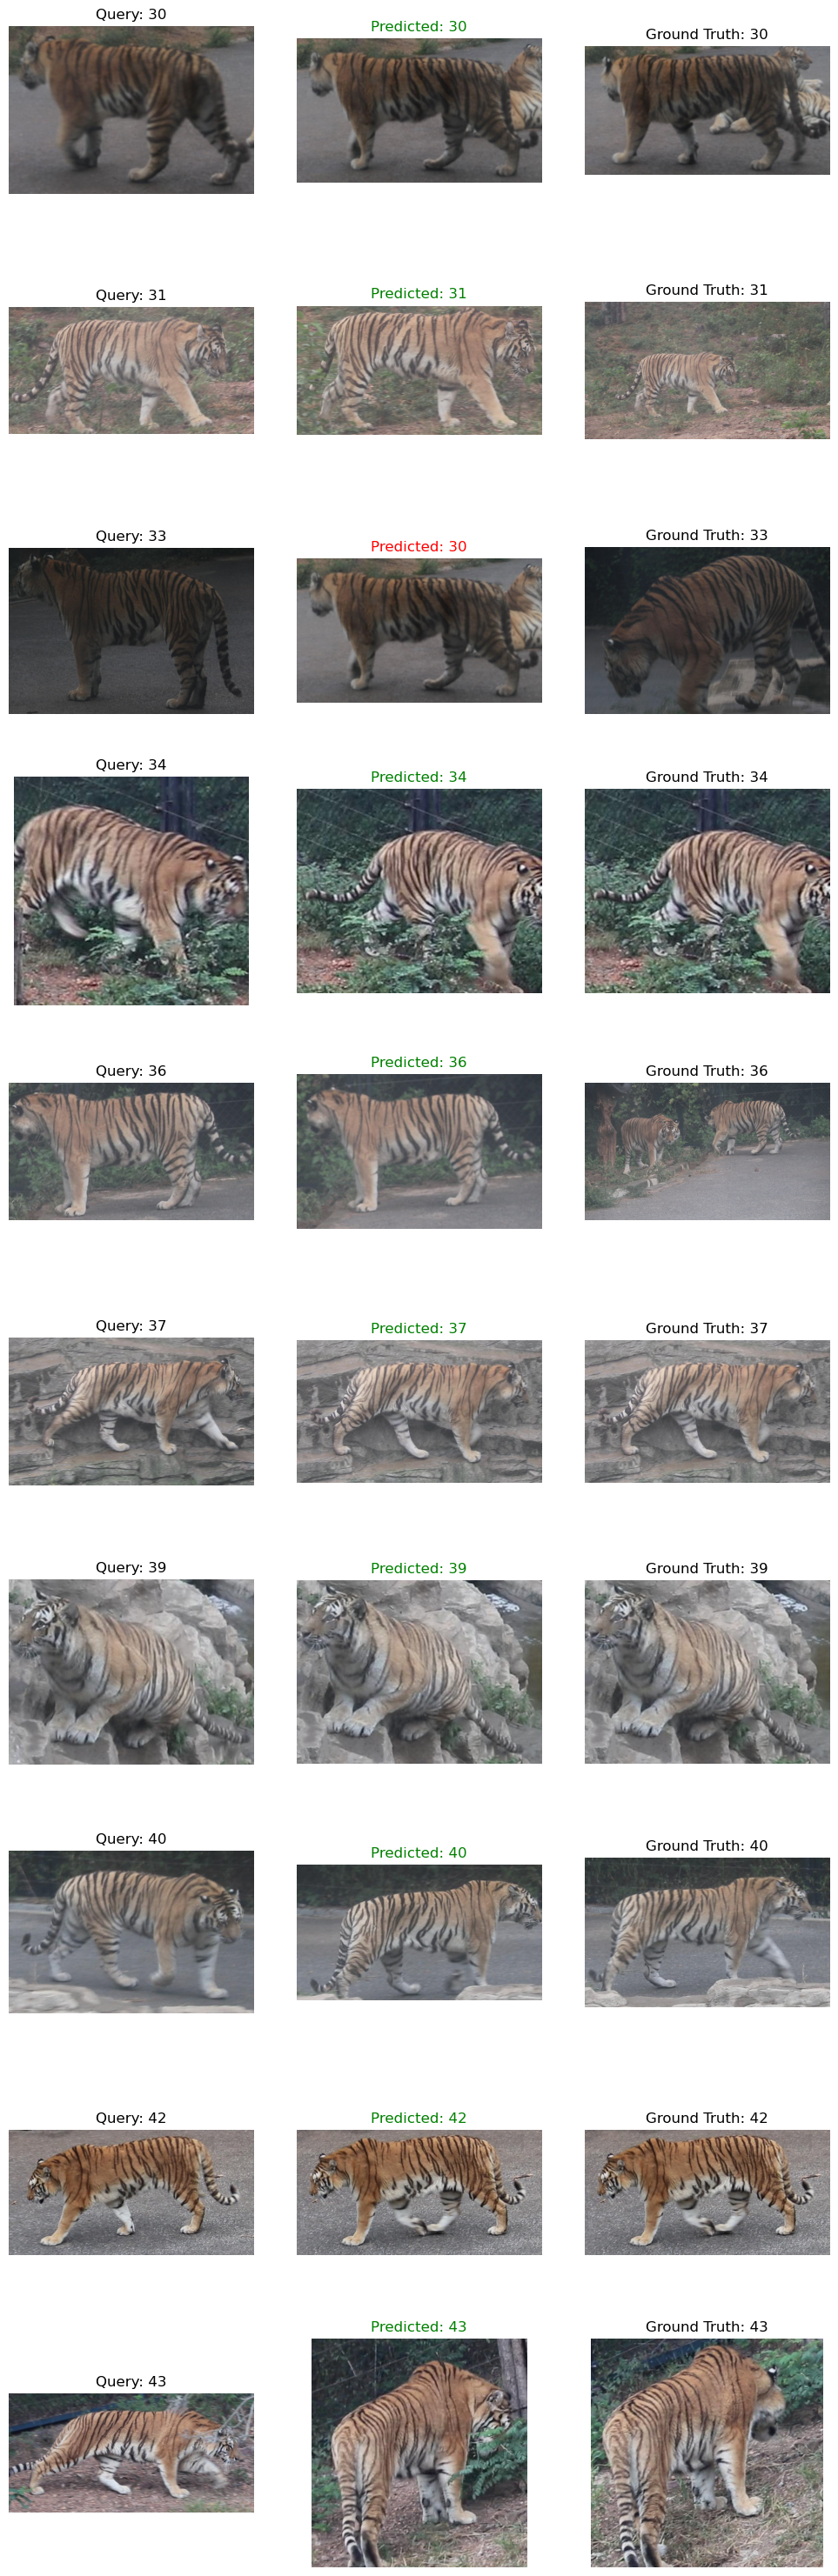

In [13]:
query_prediction_results_similarity(
    root=config['dataset'],
    query_metadata=dataset_query_P.metadata,
    db_metadata=dataset_database_P.metadata,
    query_start=20,
    similarity_scores=similarity_P['cosine'],
    num_images=10
)